# Format Results

In [61]:
import os
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

np.random.seed(0)
sns.set_style(style="whitegrid")

In [62]:
def get_results(exp_name, df_full):
    folder = exp_name
    files = os.listdir(folder)
    files = [f for f in files if re.match(r".*\.csv", f)]
    df = pd.DataFrame()
    for f in files:
        pth = os.path.join(folder, f)
        tmp = pd.read_csv(pth)
        # replace "Method" column with layer.#
        step_num = tmp['Method'].values[0].split("_")[1].split("-")[1]
        k = tmp['Method'].values[0].split("_")[6]
        tmp['Step'] = step_num
        tmp['k_val'] = k
        df = pd.concat([df, tmp])
    df['Step'] = df['Step'].astype(int)

    # add a df_full row for each layer
    k_vals = df['k_val'].unique()
    df_full_duplicated = pd.DataFrame([df_full.iloc[0]] * len(k_vals))
    df_full_duplicated['k_val'] = k_vals
    df_full_duplicated['Step'] = 0
    df = pd.concat([df, df_full_duplicated], ignore_index=True)

    df['k_val_offset'] = (df['k_val'].apply(lambda x: x.split("+")[1] if "+" in x else x)).astype(float)

    df = df.sort_values(by=['Step', 'k_val_offset']).reset_index(drop=True)

    return df

In [63]:
def chart_PF(results, full_results, retain_results, save=None, figsize=(15,20), legend_loc='lower left'):
    df_full = pd.read_csv(full_results)
    df_retain = pd.read_csv(retain_results)
    df = get_results(results, df_full)

    # create a plot for the trajectory of each layer over steps in a large plot with 28 subplots

    fig, axs = plt.subplots(5, 2, figsize=figsize, sharex=True, sharey=True)

    k_vals = df['k_val'].dropna().unique()
    if results.split('_')[-2] == "True":
        #shuffle k_vals
        k_vals = np.random.permutation(k_vals)

    for i, ax in enumerate(axs.flat):
        k_val = k_vals[i]
        df_ = df[df['k_val'] == k_val].reset_index(drop=True)

        val = int(float(k_val.split("+")[1])*100)
        label = f"{val}-{val+10}%"
        if results.split('_')[-2] == "True":
            label = "random 10%"

        sns.lineplot(x="Step", y="ROUGE Retain", data=df_, ax=ax, marker="o", label="Retain$\\uparrow$", c="seagreen", alpha=1)
        sns.lineplot(x="Step", y="ROUGE Forget", data=df_, ax=ax, marker="o", label="Forget$\\downarrow$", c="firebrick", alpha=1)
        sns.lineplot(x="Step", y="ROUGE Real Authors", data=df_, ax=ax, marker="o", label="Real Authors$\\uparrow$", c="sandybrown", alpha=0.5)
        sns.lineplot(x="Step", y="ROUGE Real World", data=df_, ax=ax, marker="o", label="Real World$\\uparrow$", c="cornflowerblue", alpha=0.5)

        # plot horizontal line for retain rouge and forget rouge
        ax.axhline(y=df_retain['ROUGE Retain'].values[0], color='seagreen', linestyle='--')
        ax.axhline(y=df_retain['ROUGE Forget'].values[0], color='firebrick', linestyle='--')
        ax.axhline(y=df_retain['ROUGE Real Authors'].values[0], color='sandybrown', linestyle='--')
        ax.axhline(y=df_retain['ROUGE Real World'].values[0], color='cornflowerblue', linestyle='--')

        #change x axis name
        ax.set_xlabel("Unlearn Step")
        ax.set_ylabel("ROUGE Score")

        ax.set_ylim(0, 1)
        # ax.tick_params(axis='x', rotation=90)

        if "tofu" in results:
            ax.set_xticks(np.arange(0, 21, 2))
        elif "knowundo" in results:
            ax.set_xticks(np.arange(0, 291, 29))

        ax.set_title(f"{label}")
        if i == 0:
            ax.legend(loc=legend_loc, ncol=4)
        else:
            ax.get_legend().remove()

    plt.tight_layout()
    plt.show()

    if save:
        fig.savefig(save, format="svg", bbox_inches='tight')

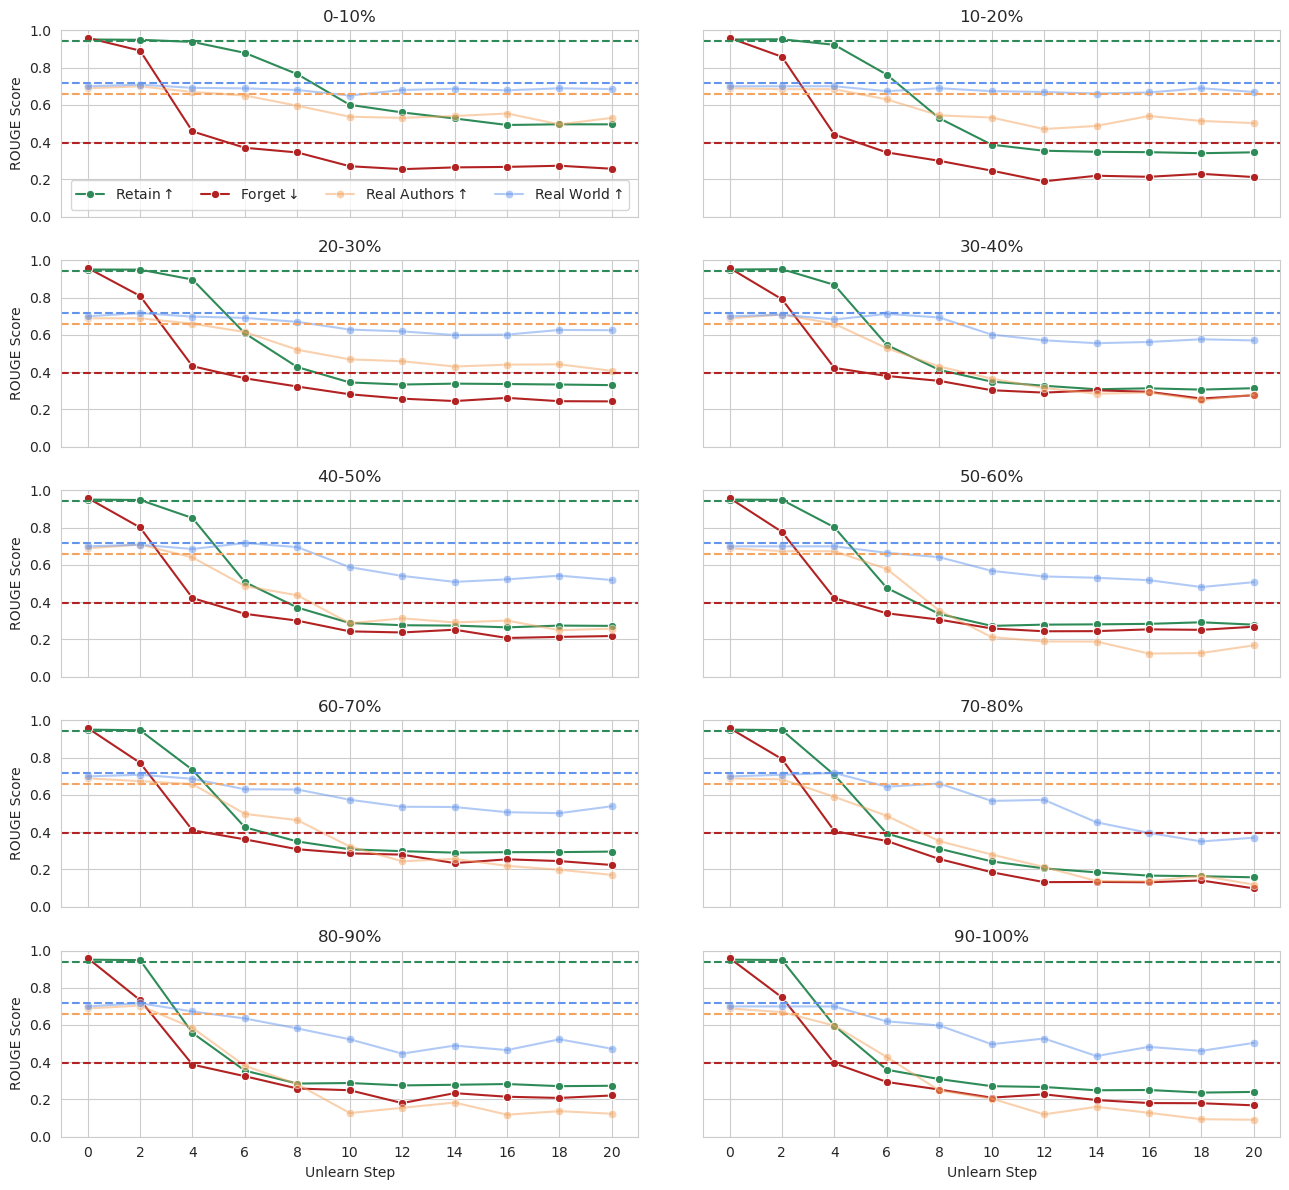

In [68]:
chart_PF(
    # results="results/qwen2-1.5b/tofu/PoT_forget01_k0.1_so-influence_3e-05_mlp,attn_False_sophia",
    results="results/qwen2-1.5b/tofu/PoT_forget01_k0.1_so-influence_5e-05_mlp,attn_False_sophia",
    full_results="results/qwen2-1.5b/tofu/qwen2-1.5b_full_tofu_checkpoint-1250_noLORA_2.5e-05_10_0.01_full_forget01_perturbed_seed42.csv",
    retain_results="results/qwen2-1.5b/tofu/qwen2-1.5b_retain_tofu_checkpoint-1237_noLORA_2.5e-05_10_0.01_retain99_forget01_perturbed_seed42.csv",
    figsize=(13,12),
    legend_loc="lower center",
    # save="figures/PoT_soir_koffset_chart.svg"
)

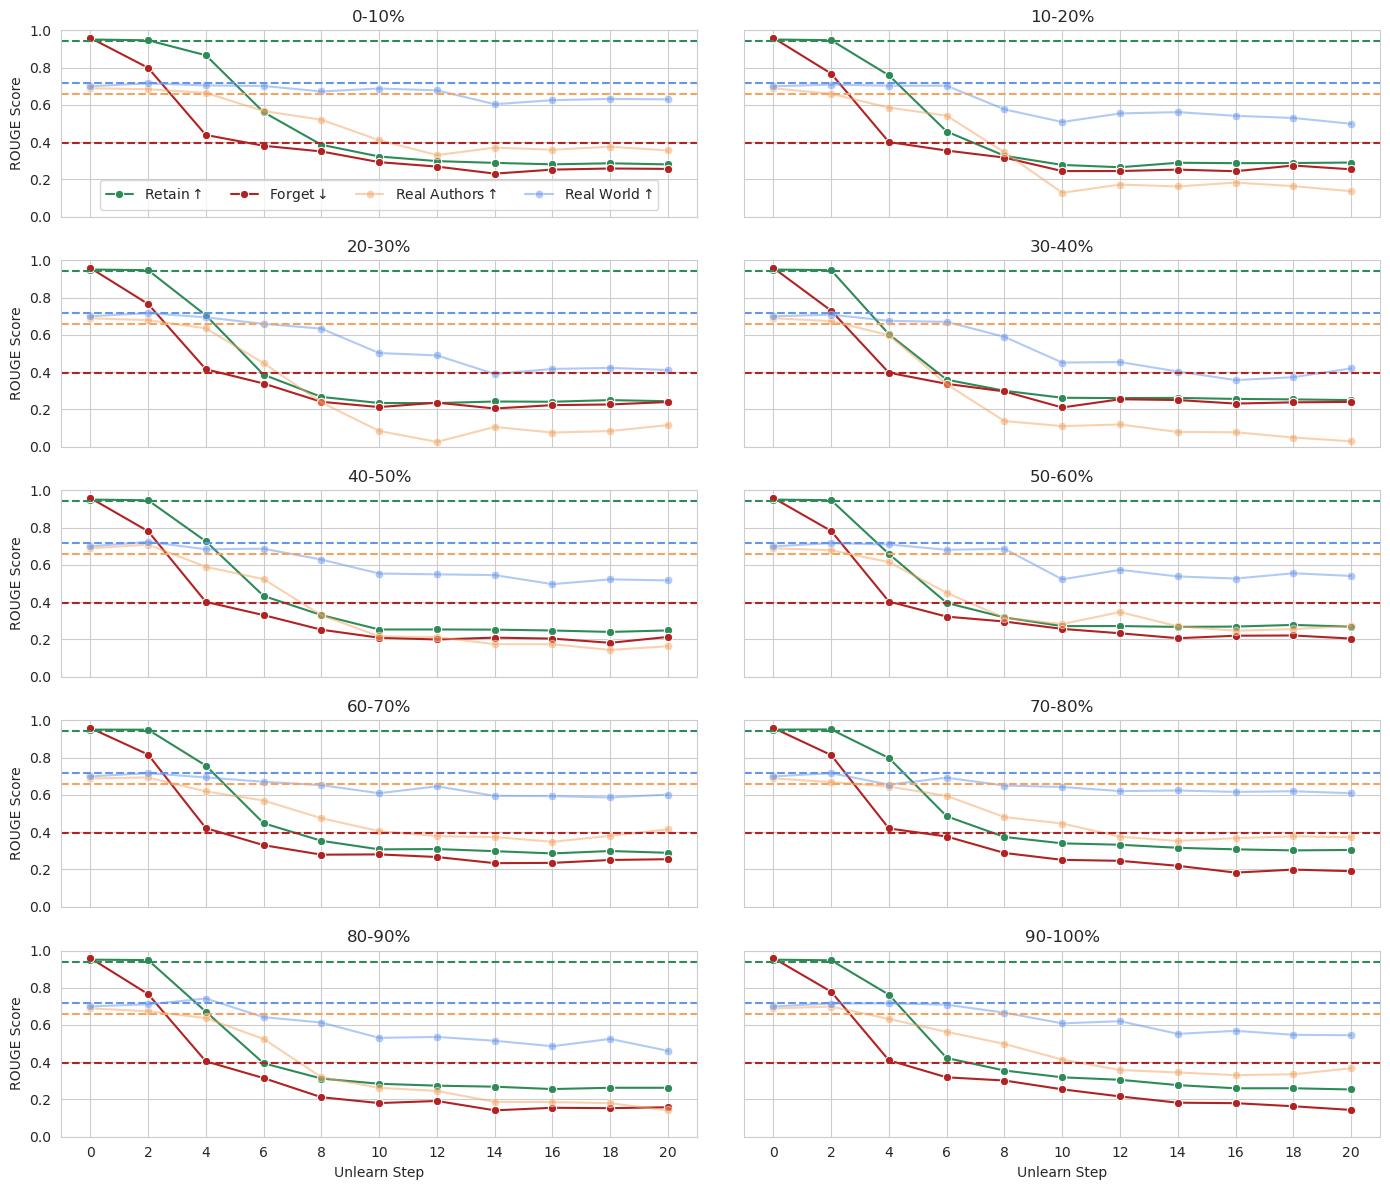

In [59]:
chart_PF(
    results="results/qwen2-1.5b/tofu/PoT_forget01_k0.1_param-deltas_5e-05_mlp,attn_False_sophia",
    full_results="results/qwen2-1.5b/tofu/qwen2-1.5b_full_tofu_checkpoint-1250_noLORA_2.5e-05_10_0.01_full_forget01_perturbed_seed42.csv",
    retain_results="results/qwen2-1.5b/tofu/qwen2-1.5b_retain_tofu_checkpoint-1237_noLORA_2.5e-05_10_0.01_retain99_forget01_perturbed_seed42.csv",
    figsize=(14,12),
    legend_loc="lower center",
    # save="figures/PoT_soir_koffset.svg"
)

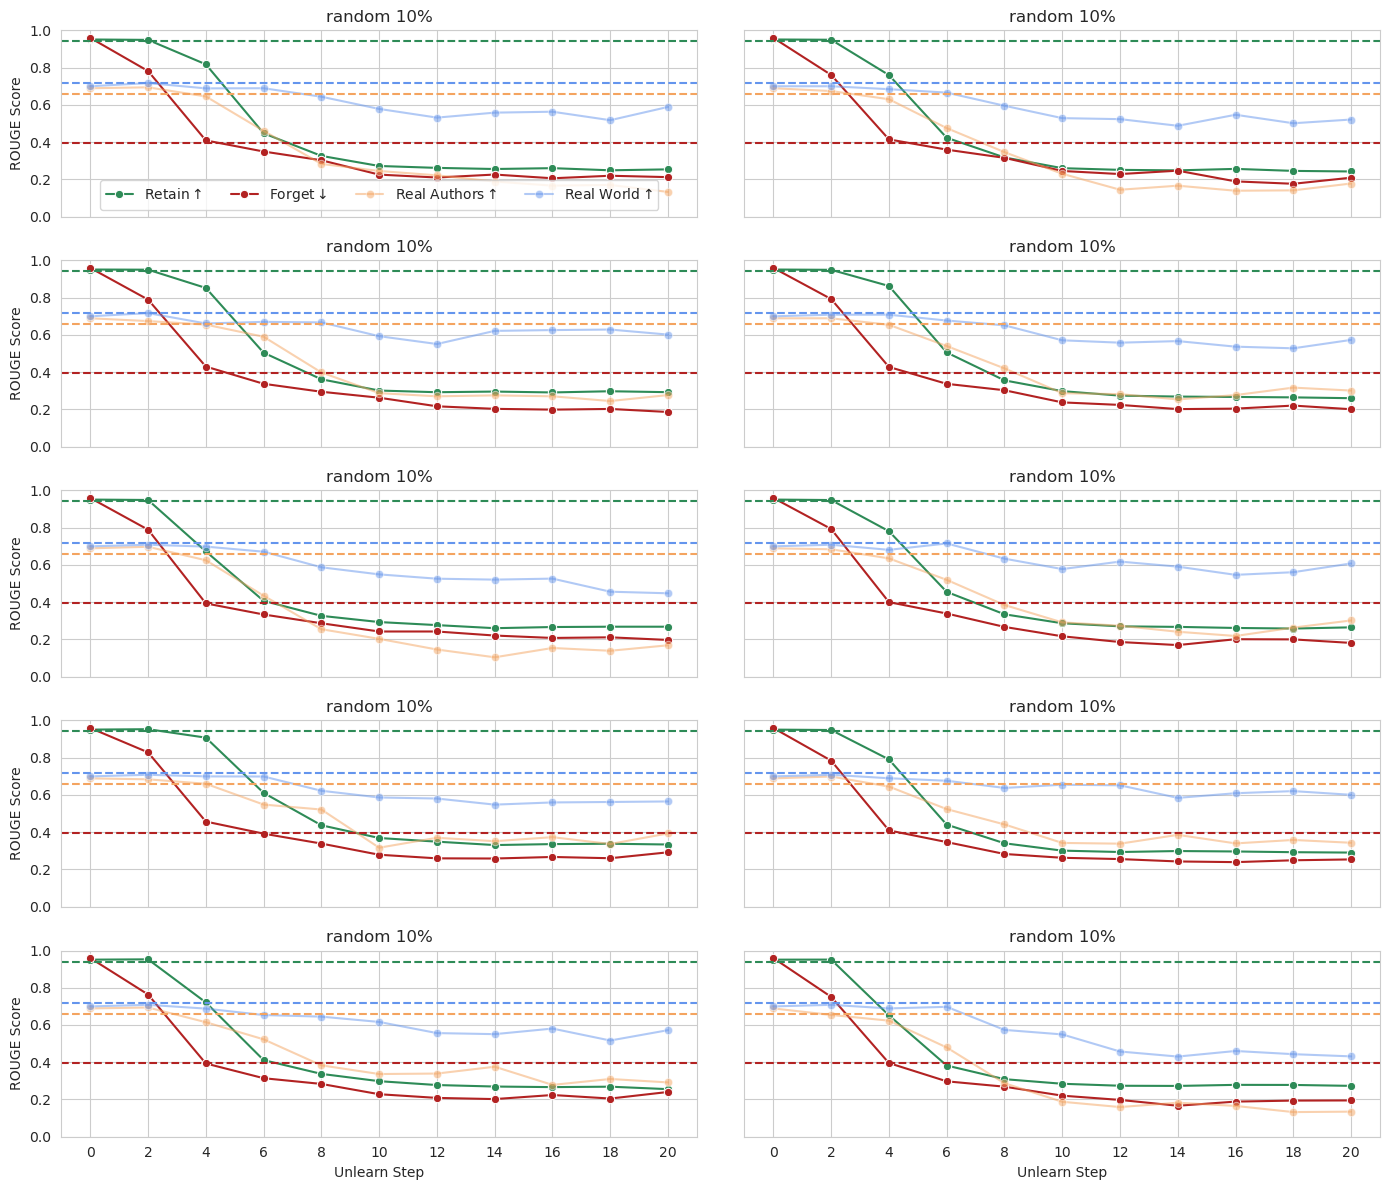

In [60]:
chart_PF(
    results="results/qwen2-1.5b/tofu/PoT_forget01_k0.1_so-influence_5e-05_mlp,attn_True_sophia",
    full_results="results/qwen2-1.5b/tofu/qwen2-1.5b_full_tofu_checkpoint-1250_noLORA_2.5e-05_10_0.01_full_forget01_perturbed_seed42.csv",
    retain_results="results/qwen2-1.5b/tofu/qwen2-1.5b_retain_tofu_checkpoint-1237_noLORA_2.5e-05_10_0.01_retain99_forget01_perturbed_seed42.csv",
    figsize=(14,12),
    legend_loc="lower center",
    # save="figures/PoT_soir_koffset.svg"
)

In [3]:
def plot_PF(results, full_results, retain_results, save=None, figsize=(12,12), default_zoom=False, xlim=(1, 0.2), ylim=(0.2, 1), legend_loc='lower left'):
    df_full = pd.read_csv(full_results)
    df_retain = pd.read_csv(retain_results)
    df = get_results(results, df_full)

    if "tofu" in results:
        checkpoint_step = 2 # tofu
    elif "knowundo" in results:
        checkpoint_step = 29 # knowundo

    def best_step(experiment, return_diff=False):
        # find the closest step to the ideal values
        df = experiment
        diff_retain = abs(df['ROUGE Retain'] - df_retain['ROUGE Retain'].values[0]) ** 2
        diff_forget = abs(df['ROUGE Forget'] - df_retain['ROUGE Forget'].values[0]) ** 2
        diff = np.sqrt(diff_retain + diff_forget)
        idx = diff.idxmin()
        if return_diff:
            return int(df.loc[idx]['Step']), diff[idx]
        else:
            return int(df.loc[idx]['Step'])


    fig, ax = plt.subplots(figsize=figsize)

    alpha = 0.5
    palette = sns.color_palette("coolwarm", 11) # hls, husl, coolwarm

    k_vals = df['k_val'].dropna().unique()
    if results.split('_')[-2] == "True":
        #shuffle k_vals
        k_vals = np.random.permutation(k_vals)

    for i, k_val in enumerate(k_vals):
        layer_df = df[df['k_val'] == k_val].reset_index(drop=True)
        color = palette[i]

        val = int(float(k_val.split("+")[1])*100)
        label = f"{val}-{val+10}%"
        if results.split('_')[-2] == "True":
            label=""
            alpha = 1
            color=palette[5]
            if i == 0:
                label = "random"

        sns.lineplot(x="ROUGE Forget", y="ROUGE Retain", data=layer_df, ax=ax, marker="o", c=color, alpha=alpha, label=f"{label}")
        step = best_step(layer_df)
        text_x = layer_df["ROUGE Forget"][step//checkpoint_step] - 0.0015
        text_y = layer_df["ROUGE Retain"][step//checkpoint_step] - 0.0015
        if results.split('_')[-2] != "True":
            ax.annotate(f"{label}", (text_x, text_y), fontsize=10, color=color, alpha=1, clip_on=True, zorder=2)


    sns.scatterplot(x="ROUGE Forget", y="ROUGE Retain", data=df_retain, ax=ax, marker="*", s=300, c="b", alpha=1, zorder=2, label="Retain")

    plt.xlim(xlim)
    plt.ylim(ylim)

    if default_zoom:
        plt.xlim(0.55, 0.35)
        plt.ylim(0.8, 1)

    plt.legend(loc=legend_loc)

    plt.show()

    # save
    if save:
        fig.savefig(save, format='svg', bbox_inches='tight')


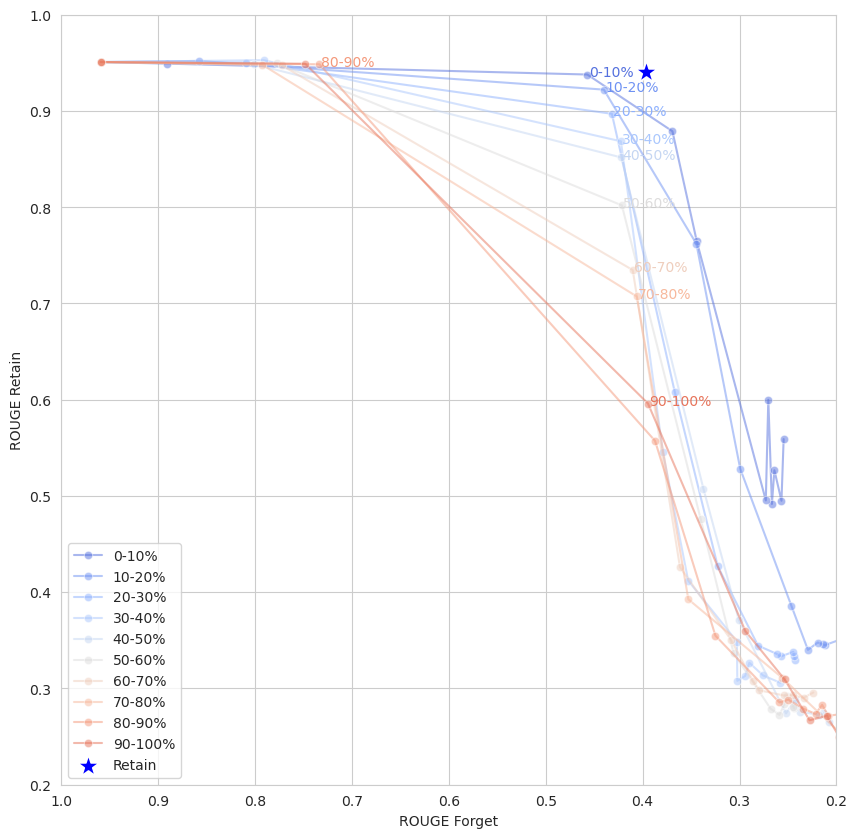

In [6]:
plot_PF(
    # results="results/qwen2-1.5b/tofu/PoT_forget01_k0.1_so-influence_3e-05_mlp,attn_False_sophia",
    results="results/qwen2-1.5b/tofu/PoT_forget01_k0.1_so-influence_5e-05_mlp,attn_False_sophia",
    full_results="results/qwen2-1.5b/tofu/qwen2-1.5b_full_tofu_checkpoint-1250_noLORA_2.5e-05_10_0.01_full_forget01_perturbed_seed42.csv",
    retain_results="results/qwen2-1.5b/tofu/qwen2-1.5b_retain_tofu_checkpoint-1237_noLORA_2.5e-05_10_0.01_retain99_forget01_perturbed_seed42.csv",
    figsize=(10,10),
    # default_zoom=True,
    # xlim=(0.55, 0.35),
    # ylim=(0.8, 1),
    # legend_loc="lower left",
    # save="figures/PoT_soir_koffset.svg"
)

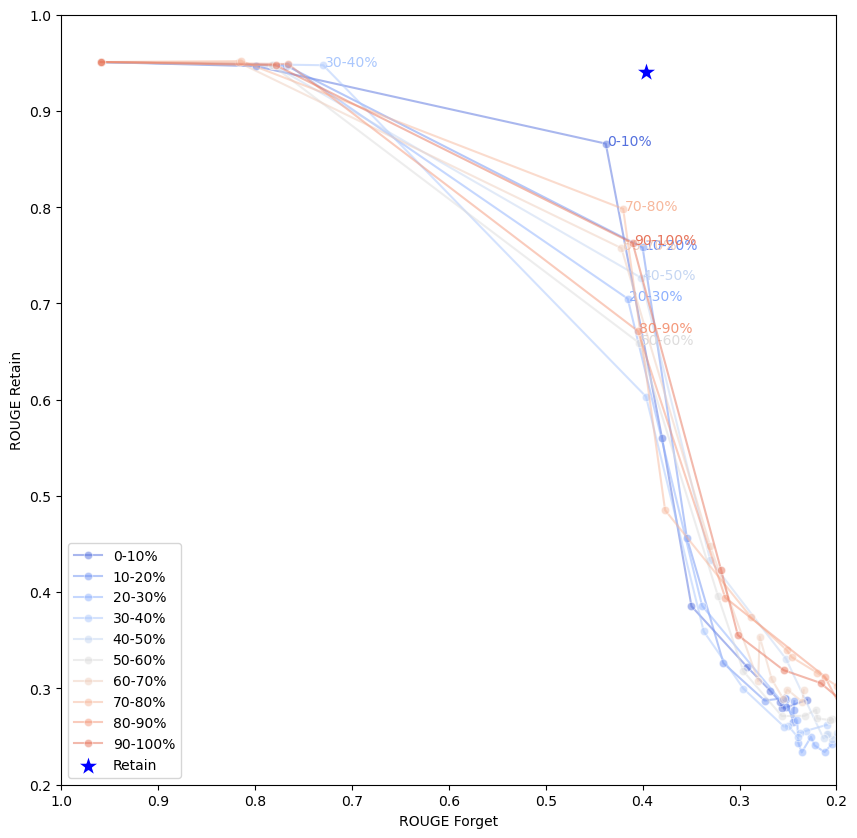

In [114]:
plot_PF(
    # results="results/qwen2-1.5b/tofu/PoT_forget01_k0.1_param-deltas_3e-05_mlp,attn_False_sophia",
    results="results/qwen2-1.5b/tofu/PoT_forget01_k0.1_param-deltas_5e-05_mlp,attn_False_sophia",
    full_results="results/qwen2-1.5b/tofu/qwen2-1.5b_full_tofu_checkpoint-1250_noLORA_2.5e-05_10_0.01_full_forget01_perturbed_seed42.csv",
    retain_results="results/qwen2-1.5b/tofu/qwen2-1.5b_retain_tofu_checkpoint-1237_noLORA_2.5e-05_10_0.01_retain99_forget01_perturbed_seed42.csv",
    figsize=(10,10),
    # default_zoom=True,
    # xlim=(0.55, 0.35),
    # ylim=(0.8, 1),
    # legend_loc="lower left",
    # save="figures/PoT_param_deltas_koffset.svg"
)

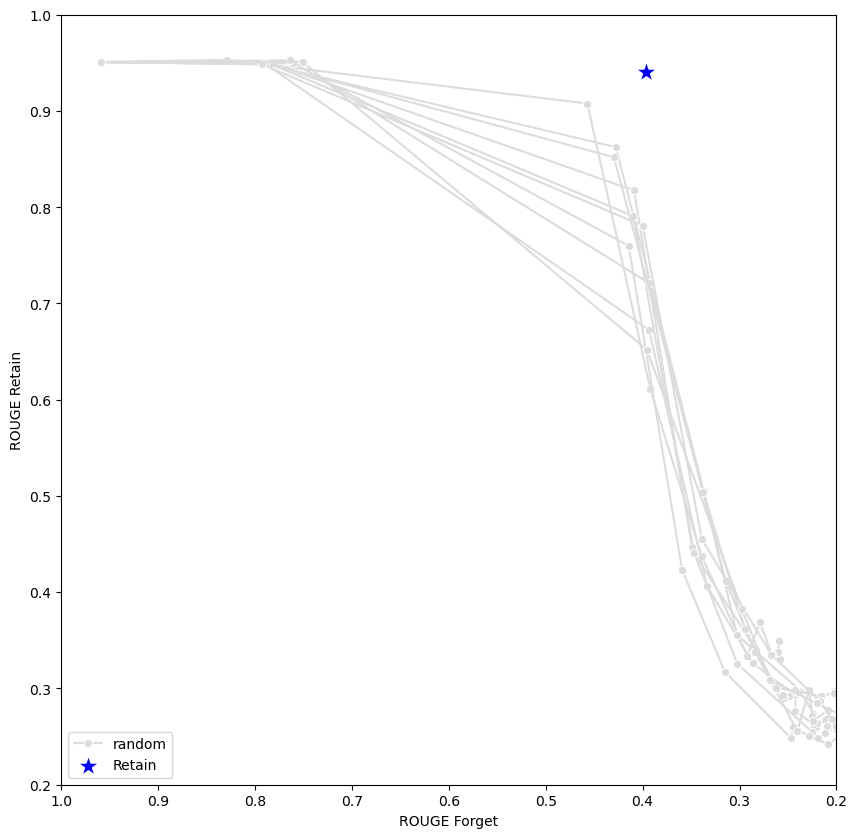

In [115]:
plot_PF(
    results="results/qwen2-1.5b/tofu/PoT_forget01_k0.1_so-influence_5e-05_mlp,attn_True_sophia",
    full_results="results/qwen2-1.5b/tofu/qwen2-1.5b_full_tofu_checkpoint-1250_noLORA_2.5e-05_10_0.01_full_forget01_perturbed_seed42.csv",
    retain_results="results/qwen2-1.5b/tofu/qwen2-1.5b_retain_tofu_checkpoint-1237_noLORA_2.5e-05_10_0.01_retain99_forget01_perturbed_seed42.csv",
    figsize=(10,10),
    # default_zoom=True,
    # xlim=(0.55, 0.35),
    # ylim=(0.8, 1),
    # legend_loc="lower left",
    # save="figures/PoT_random_koffset.svg"
)

In [5]:
def best_step(experiment, return_diff=False):
    # find the closest step to the ideal values
    df = experiment
    diff_retain = abs(df['ROUGE Retain'] - df_retain['ROUGE Retain'].values[0]) ** 2
    diff_forget = abs(df['ROUGE Forget'] - df_retain['ROUGE Forget'].values[0]) ** 2
    diff = np.sqrt(diff_retain + diff_forget)
    idx = diff.idxmin()
    if return_diff:
        return int(df.loc[idx]['Step']), diff[idx]
    else:
        return int(df.loc[idx]['Step'])

In [6]:
palette = sns.color_palette("coolwarm", 11)
palette

[(0.32860444731764704, 0.43971182997647057, 0.8695872625411765),
 (0.4358148063058824, 0.5707073031529412, 0.951717381282353),
 (0.5543118699137254, 0.6900970112156862, 0.9955155482352941),
 (0.6672529243333334, 0.7791764569999999, 0.992959213),
 (0.7727059486039215, 0.8389782172392156, 0.9493187599137255),
 (0.8674276350862745, 0.864376599772549, 0.8626024620196079),
 (0.9383263563333333, 0.8089165520313726, 0.741161515027451),
 (0.968203399, 0.7208441, 0.6122929913333334),
 (0.9566532109764706, 0.598033822717647, 0.4773022923529412),
 (0.9057834780117647, 0.4551856921647059, 0.35533588384705883),
 (0.8204010983882353, 0.2867649126352941, 0.2451595198)]

In [7]:
for i, k_val in enumerate(results_df['k_val'].dropna().unique()):
    layer_df = results_df[results_df['k_val'] == k_val].reset_index(drop=True)
    step, diff = best_step(layer_df,return_diff=True)
    print(f"Best diff for k={k_val}: {diff:.4f} at step {step}")


Best diff for k=0.1+0: 0.0308 at step 18
Best diff for k=0.1+0.1: 0.0389 at step 10
Best diff for k=0.1+0.2: 0.0518 at step 6
Best diff for k=0.1+0.3: 0.0586 at step 6
Best diff for k=0.1+0.4: 0.0669 at step 6
Best diff for k=0.1+0.5: 0.0678 at step 6
Best diff for k=0.1+0.6: 0.0738 at step 6
Best diff for k=0.1+0.7: 0.1239 at step 6
Best diff for k=0.1+0.8: 0.1010 at step 4
Best diff for k=0.1+0.9: 0.0999 at step 4


In [15]:
for i, k_val in enumerate(results_df['k_val'].dropna().unique()):
    layer_df = results_df[results_df['k_val'] == k_val].reset_index(drop=True)
    step, diff = best_step(layer_df,return_diff=True)
    print(f"Best diff for k={k_val}: {diff:.4f} at step {step}")


Best diff for k=0.1+0: 0.0518 at step 6
Best diff for k=0.1+0.1: 0.0569 at step 6
Best diff for k=0.1+0.2: 0.0562 at step 6
Best diff for k=0.1+0.3: 0.1205 at step 4
Best diff for k=0.1+0.4: 0.0721 at step 6
Best diff for k=0.1+0.5: 0.1388 at step 6
Best diff for k=0.1+0.6: 0.1050 at step 6
Best diff for k=0.1+0.7: 0.0643 at step 6
Best diff for k=0.1+0.8: 0.1133 at step 6
Best diff for k=0.1+0.9: 0.0659 at step 6


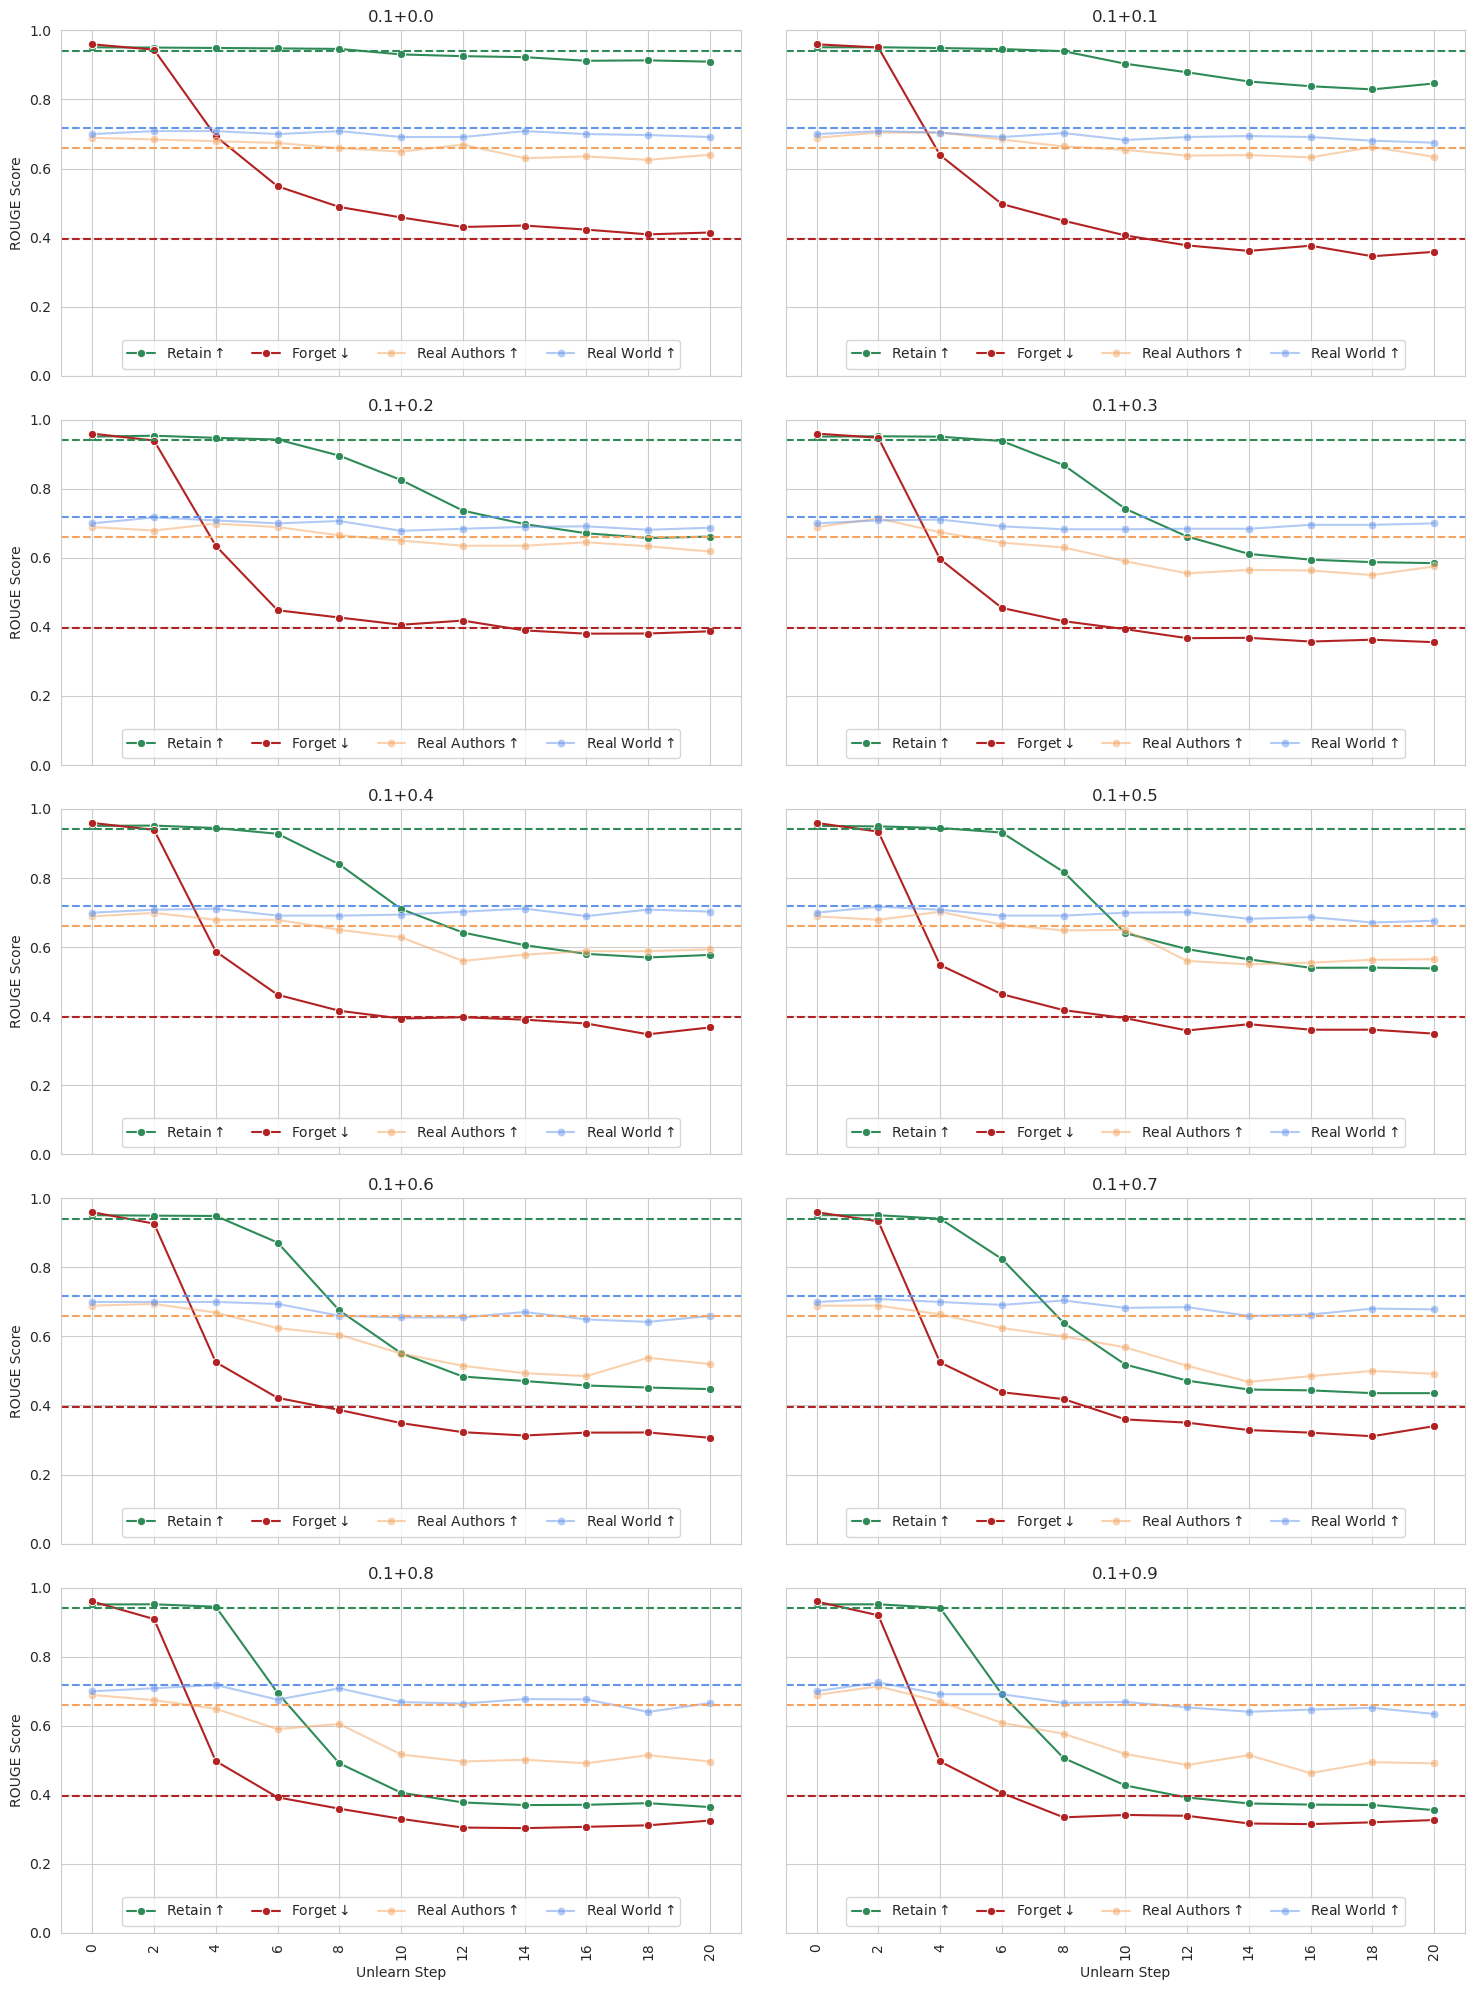

In [106]:
# create a plot for the trajectory of each layer over steps in a large plot with 28 subplots
sns.set_style(style="whitegrid")

fig, axs = plt.subplots(5, 2, figsize=(15, 20), sharex=True, sharey=True)

for i, ax in enumerate(axs.flat):
    k_val = results_df['k_val_offset'].unique()[i]
    df_ = results_df[results_df['k_val_offset'] == k_val].reset_index(drop=True)
    sns.lineplot(x="Step", y="ROUGE Retain", data=df_, ax=ax, marker="o", label="Retain$\\uparrow$", c="seagreen", alpha=1)
    sns.lineplot(x="Step", y="ROUGE Forget", data=df_, ax=ax, marker="o", label="Forget$\\downarrow$", c="firebrick", alpha=1)
    sns.lineplot(x="Step", y="ROUGE Real Authors", data=df_, ax=ax, marker="o", label="Real Authors$\\uparrow$", c="sandybrown", alpha=0.5)
    sns.lineplot(x="Step", y="ROUGE Real World", data=df_, ax=ax, marker="o", label="Real World$\\uparrow$", c="cornflowerblue", alpha=0.5)

    # plot horizontal line for retain rouge and forget rouge
    ax.axhline(y=df_retain['ROUGE Retain'].values[0], color='seagreen', linestyle='--')
    ax.axhline(y=df_retain['ROUGE Forget'].values[0], color='firebrick', linestyle='--')
    ax.axhline(y=df_retain['ROUGE Real Authors'].values[0], color='sandybrown', linestyle='--')
    ax.axhline(y=df_retain['ROUGE Real World'].values[0], color='cornflowerblue', linestyle='--')

    #change x axis name
    ax.set_xlabel("Unlearn Step")
    ax.set_ylabel("ROUGE Score")

    ax.set_ylim(0, 1)
    ax.tick_params(axis='x', rotation=90)

    if "tofu" in results:
        ax.set_xticks(np.arange(0, 21, 2))
    elif "knowundo" in results:
        ax.set_xticks(np.arange(0, 291, 29))

    ax.set_title(f"0.1+{k_val}")

    # move legend to bottom center
    ax.legend(loc='lower center', ncol=4)

plt.tight_layout()
plt.show()

# fig.savefig("figures/PT_3e05_sharedaxis_tofu.svg", format="svg")